# Accelerate VGG19 Inference on Intel® Gen4 Xeon®  Sapphire Rapids

## Instroduction


This example shows a whole pipeline:

1. Train an image classification model [VGG19](https://arxiv.org/abs/1409.1556) by transfer learning based on [TensorFlow Hub](https://tfhub.dev) trained model.

2. Quantize the FP32 Keras model and get a INT8 PB model by Intel® Neural Compressor.

3. Test and compare the performance of FP32 & INT8 models.

This example can be executed on Intel® CPU which supports Intel® AVX-512 Vector Neural Network Instructions (VNNI) or Intel® Advanced Matrix Extensions (AMX). There will be more performance improvement on Intel® CPU with AMX.

## Import Depended Library

In [1]:
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

import neural_compressor as inc
print("neural_compressor version {}".format(inc.__version__))

import tensorflow as tf
print("tensorflow {}".format(tf.__version__))

from IPython import display

2023-03-16 13:43:44.750296: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-16 13:43:44.903467: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /glob/development-tools/versions/oneapi/2023.0.1/oneapi/intelpython/latest/lib/libfabric:
2023-03-16 13:43:44.903510: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-16 13:43:52.075081: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic 

neural_compressor version 2.0
tensorflow 2.11.0


In [5]:
%env TF_ENABLE_ONEDNN_OPTS=1

env: TF_ENABLE_ONEDNN_OPTS=1


## Transfer Learning

### Dataset

We use a publicly available dataset [ibean](https://github.com/AI-Lab-Makerere/ibean/) and download from internet. The dataset size is about 170MB which is small enough to be easy download and learn deep learning in short time.

It includes leaf images of beans which consist of 3 classes: 2 disease classes and the healthy class. The dataset is divided into 3 parts: train, test, validation.

A record include:
1. Image: shape (500, 500, 3), data type is uint8
2. label: class label (num_classes=3), data type is uint64


In [3]:
# define class number
class_num=3

def load_raw_dataset():
    raw_datasets, raw_info = tfds.load(name = 'beans', with_info = True,
                                       as_supervised = True, 
                                       split = ['train', 'test'])
    return raw_datasets, raw_info

### Pre-Trained Model

We will download a trained VGG19 FP32 Keras model from TensorFlow Hub. 

The pre-trained model's input is (32, 32, 3) and output is 10 softmax logits for 10 classes. 

We need to convert the input image to (32, 32, 3)


In [3]:
# define input image size and class number
w=h=32

### Build Model

We call hub.KerasLayer() to download the pre-trained model and wraps it as a Keras Layer.

We disable the training capability of the trained FP32 model part, and add 3 tf.keras.layers.Dense layers and 2 tf.keras.layers.Dropout layers. The final tf.keras.layers.Dense is with class number of the data and  activation function **softmax**.

During the training, only the added layers are training. With the feature extractor function of pre-trained layers, it's easy to train the model in short time with the custom dataset in short time.

In [5]:
def build_model(w, h, class_num):
    url = 'https://tfhub.dev/deepmind/ganeval-cifar10-convnet/1'
    feature_extractor_layer = hub.KerasLayer(url, input_shape = (w, h, 3))
    feature_extractor_layer.trainable = False

    model = tf.keras.Sequential(
        [
            feature_extractor_layer,
            #tf.keras.layers.Dropout(0.4),
            tf.keras.layers.Dense(class_num, activation = 'softmax')
        ]
    )

    model.summary()

    model.compile(
        optimizer = tf.keras.optimizers.Adam(),
        loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
        metrics = ['acc']
    )    
    return model


model = build_model(w, h, class_num)

2023-03-16 13:45:04.100278: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/u177489/.local/lib/python3.9/site-packages/cv2/../../lib64:/glob/development-tools/versions/oneapi/2023.0.1/oneapi/intelpython/latest/lib/libfabric:
2023-03-16 13:45:04.100341: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-16 13:45:04.100380: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (s001-n014): /proc/driver/nvidia/version does not exist
2023-03-16 13:45:04.100819: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AV

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 10)                7796426   
                                                                 
 dense (Dense)               (None, 3)                 33        
                                                                 
Total params: 7,796,459
Trainable params: 33
Non-trainable params: 7,796,426
_________________________________________________________________


### Data Precessing

The pre-trained model's input shape is (32, 32, 3), so we must resize the input of dataset to same shape for transfer learning.

The raw input data is INT8 type, we need to convert it to FP32.

In [6]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32)/255.0
    return tf.image.resize(image, [w, h]), tf.one_hot(label, class_num)

### Dataset Loader

In [7]:
def load_dataset(batch_size = 32):
    datasets, info = load_raw_dataset()
    return [dataset.map(preprocess).batch(batch_size) for dataset in datasets]

### Training Model

Train the model with 5 epochs.

In [8]:
def train_model(model, epochs=1):
    train_dataset, test_dataset = load_dataset()
    hist = model.fit(train_dataset, epochs = epochs, validation_data = test_dataset)
    result = model.evaluate(test_dataset)
    
epochs=5
train_model(model, epochs)

Epoch 1/5
33/33 [==============================] - 3s 66ms/step - loss: 5.2552 - acc: 0.3404 - val_loss: 4.2746 - val_acc: 0.3516
Epoch 2/5
33/33 [==============================] - 2s 48ms/step - loss: 4.3372 - acc: 0.3375 - val_loss: 3.5110 - val_acc: 0.3516
Epoch 3/5
33/33 [==============================] - 2s 49ms/step - loss: 3.6226 - acc: 0.3433 - val_loss: 2.9384 - val_acc: 0.3516
Epoch 4/5
33/33 [==============================] - 2s 48ms/step - loss: 3.0685 - acc: 0.3288 - val_loss: 2.4880 - val_acc: 0.3359
Epoch 5/5
4/4 [==============================] - 0s 37ms/step - loss: 2.1281 - acc: 0.3281


### Save Model

In [9]:
def save_model(model, model_path):    
    model.save(model_path)
    print("Save model to {}".format(model_path))
    
model_fp32_path="model_keras.fp32"
save_model(model, model_fp32_path)

INFO:tensorflow:Assets written to: model_keras.fp32/assets


INFO:tensorflow:Assets written to: model_keras.fp32/assets


Save model to model_keras.fp32


### Test Model by Single Image

2023-03-16 13:46:21.928912: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


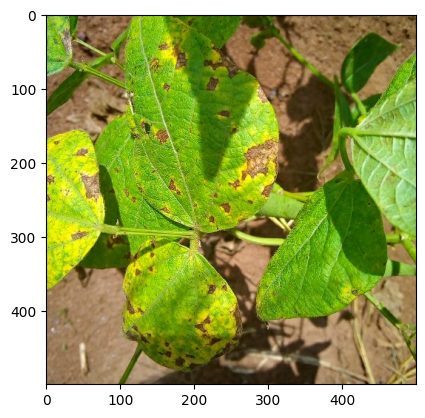

Actual Label : angular_leaf_spot
Predicted Label : angular_leaf_spot


In [10]:
%matplotlib inline

import matplotlib.pylab as plt
import numpy as np


def verify_single_image(model, test_dataset, info):
    for sample in datasets[-1].take(1):
        [image, label] = sample
        image_fp32, label_arr = preprocess(image, label)
        image_fp32 = np.expand_dims(image_fp32, axis = 0)
        pred = model(image_fp32)


        plt.figure()
        plt.imshow(image)
        plt.show()

        print("Actual Label : %s" %info.features['label'].names[label.numpy()])
        print("Predicted Label : %s" %info.features['label'].names[np.argmax(pred)])
        
datasets, info = load_raw_dataset()
verify_single_image(model, datasets[-1], info)

## Quantize Model by Intel® Neural Compressor

### Custom Dataset

The custom dataset class must provide two methods: `__len__()` and `__getitem__()`.

In this case, use the integrated metric function in this tool. So the dataset format must follow the requirement of default metric function. So the label format is class index, instead of categorical vector (one-hot encoding)

In [1]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32)/255.0
    return  tf.image.resize(image, [w, h]), np.array(tf.one_hot(label, class_num))    


def load_raw_dataset():
    raw_datasets, raw_info = tfds.load(name = 'beans', with_info = True,
                                       as_supervised = True, 
                                       split = ['train', 'test'])
                                       
    return raw_datasets, raw_info
    
class Dataset(object):
    def __init__(self):
        datasets , info = load_raw_dataset()        
        self.test_dataset = [preprocess(v, l) for v,l in datasets[-1]]
    
    def __getitem__(self, index):
        return self.test_dataset[index]

    def __len__(self):
        return len(list(self.test_dataset))


neural_compressor version 2.0


2023-03-16 13:58:50.180411: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-16 13:58:50.312195: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/u177489/.local/lib/python3.9/site-packages/cv2/../../lib64:/glob/development-tools/versions/oneapi/2023.0.1/oneapi/intelpython/latest/lib/libfabric:
2023-03-16 13:58:50.312234: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-16 13:58:55.932882: W tensorflow/compiler/xla/stream_ex

tensorflow 2.11.0


/home/u177489/.conda/envs/inc200/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Quantize API

#### Quantization Plus BF16 on Sapphire Rapids (SPR) (Optional)

If you want to try Quantization Plus BF16 on **none SPR**, please enable it forcely.

The quantized model can be accelerated when run inference on SPR.

```
import os
os.environ["FORCE_BF16"] = "1"
os.environ["MIX_PRECISION_TEST"] = "1"
```

#### Quantize by Intel® Neural Compressor API

Create the dataloader by custom data defined above. Call Intel® Neural Compressor API to quantize the FP32 model.

The executing time depends on the size of dataset and accuracy target.

#### Execute to Quantize on Local SPR server.

In [6]:
from neural_compressor.data import DataLoader
from neural_compressor.quantization import fit
from neural_compressor.config import PostTrainingQuantConfig, AccuracyCriterion

def auto_tune(input_graph_path, batch_size, int8_pb_file):
    dataset = Dataset()
    dataloader = DataLoader(framework='tensorflow', dataset=dataset, batch_size = batch_size)
    
    #Define accuracy criteria and tolerable loss
    config = PostTrainingQuantConfig(
    accuracy_criterion = AccuracyCriterion(
      higher_is_better=True, 
      criterion='relative',  
      tolerable_loss=0.01  
      )
    )
    q_model = fit(
        model=input_graph_path,
        conf=config,
        calib_dataloader=dataloader,
        eval_dataloader=dataloader
        )

    return q_model



batch_size = 32
model_fp32_path="model_keras.fp32"
int8_pb_file = "model_pb.int8"
q_model = auto_tune(model_fp32_path,  batch_size, int8_pb_file)
q_model.save(int8_pb_file)
print("Save quantized model to {}".format(int8_pb_file))

2023-03-16 14:01:16 [WARNING] Force convert framework model to neural_compressor model.
2023-03-16 14:01:17.022708: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2023-03-16 14:01:17 [WARNING] Output tensor names should not be empty.
2023-03-16 14:01:17 [WARNING] Input tensor names is empty.


INFO:tensorflow:Assets written to: /tmp/tmpyzdx4wk6/assets


INFO:tensorflow:Assets written to: /tmp/tmpyzdx4wk6/assets
2023-03-16 14:01:19.714822: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-03-16 14:01:19.714962: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-16 14:01:20.618641: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-03-16 14:01:20.619024: I tensorflow/core/grappler/clusters/single_machine.cc:358] Starting new session
2023-03-16 14:01:22 [INFO] ConvertLayoutOptimizer elapsed time: 0.15 ms
2023-03-16 14:01:22 [INFO] Pass ConvertPlaceholderToConst elapsed time: 1.02 ms
2023-03-16 14:01:22 [INFO] Pass SwitchOptimizer elapsed time: 3.49 ms
2023-03-16 14:01:22.291499: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
2023-03-16 14:01:22.291646: I tensorflow/core/grappler/clusters/single_machin

AttributeError: 'NoneType' object has no attribute 'save'

## Test the Performance & Accuracy

We use same script to test the perfomrance and accuracy of the FP32 and INT8 models.

Use 4 CPU cores to test process.


### Execute to Quantizae on Local SPR server.

#### Test FP32 Model

In [ ]:
%%time
!numactl -C 0-3 python profiling_inc.py --input-graph=./model_keras.fp32 --omp-num-threads=4 --num-inter-threads=1 --num-intra-threads=4 --index=32

#### Test INT8 Model

In [ ]:
%%time
!numactl -C 0-3 python profiling_inc.py --input-graph=./model_pb.int8 --omp-num-threads=4 --num-inter-threads=1 --num-intra-threads=4 --index=8

### Compare the Result

In [ ]:
!python compare_perf.py

Show result by graphic.

In [ ]:
from IPython.display import Image, display

listOfImageNames = ['fp32_int8_aboslute.png',
                    'fp32_int8_times.png']

for imageName in listOfImageNames:
    display(Image(filename=imageName))

# Citation

```
@ONLINE {beansdata,
    author="Makerere AI Lab",
    title="Bean disease dataset",
    month="January",
    year="2020",
    url="https://github.com/AI-Lab-Makerere/ibean/"
}
```